Here we analyze the price data of FFR and FCR from the sheets

In [2]:
import pandas as pd
import numpy as np

C:\Users\carlv\AppData\Local\Temp\ipykernel_49772\2162656668.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
df_fcr = pd.read_csv("data/FCR_2024.csv", on_bad_lines='skip', sep=';')

In [4]:
# modifications for nicer readibility
df_fcr.iloc[:, 1] = df_fcr.iloc[:, 1].replace(',', '.', regex=True).astype(float).round(2)
df_fcr = df_fcr.iloc[:-1 , :]
df_fcr["Datum"] = pd.to_datetime(df_fcr["Datum"], format='mixed')   #"%Y-%M-%D %H:%M:%S")  # 2025-02-01 22:00:00

In [5]:
df_ffr_2024 = pd.read_excel('data/FFR_2024.xlsx')
df_ffr_2023 = pd.read_excel('data/FFR_2023.xlsx')
df_ffr_2022 = pd.read_excel('data/FFR_2022.xlsx')
SEK_TO_EURO = 0.09

In [15]:
df_ffr_fingrid = pd.read_csv("data/FFR_Fingrid.csv", on_bad_lines='skip', sep=';')

In [16]:
def format_ffr(df, year_offset, name) -> pd.DataFrame:
    df.columns = df.iloc[1, :]
    df = df.iloc[2:, 0:2]
    df.iloc[:, 1:] = df.iloc[:, 1:].astype(float) * SEK_TO_EURO
    df.rename(columns={'Timme': 'Datum', 'Marginalpris (SEK/MW)': f'FFR (EUR/MW) {name}'}, inplace=True)
    df["Datum"] = pd.to_datetime(df["Datum"], format='mixed')
    # add one year because of year mismatch
    if year_offset:  df["Datum"] = df["Datum"] + pd.DateOffset(years=year_offset)
    return df

In [17]:
df_ffr_fingrid.drop('endTime', inplace=True, axis=1)
df_ffr_fingrid.rename(columns={'startTime': 'Datum', 'Fast Frequency Reserve FFR, price': 'FFR (EUR/MW) Fingrid'}, inplace=True)
df_ffr_fingrid["Datum"] = pd.to_datetime(df_ffr_fingrid["Datum"], format='mixed')

In [29]:
df_ffr_2024 = format_ffr(df_ffr_2024, year_offset=0, name='2024')
df_ffr_2023 = format_ffr(df_ffr_2023, year_offset=1, name='2023')
df_ffr_2022 = format_ffr(df_ffr_2022, year_offset=2, name='2022')
df_ffrs = [df_ffr_2024, df_ffr_2023, df_ffr_2022]

In [30]:
# merge
df_merged = df_fcr[['Datum', 'FCR-N Pris (EUR/MW)']]
for df in df_ffrs:
    df_merged = pd.merge(df_merged, df, on='Datum', how='left')

## plot data

<Axes: xlabel='Datum'>

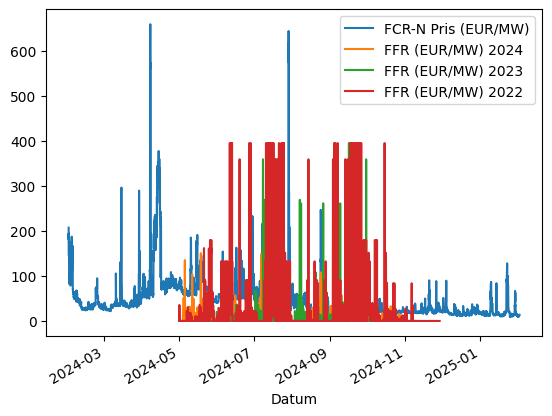

In [116]:
df_merged.plot(x='Datum')

C:\Users\carlv\AppData\Local\Temp\ipykernel_45132\751878038.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_merged_notna.fillna(0).plot(kind='hist', alpha=0.5, bins=30)


<Axes: ylabel='Frequency'>

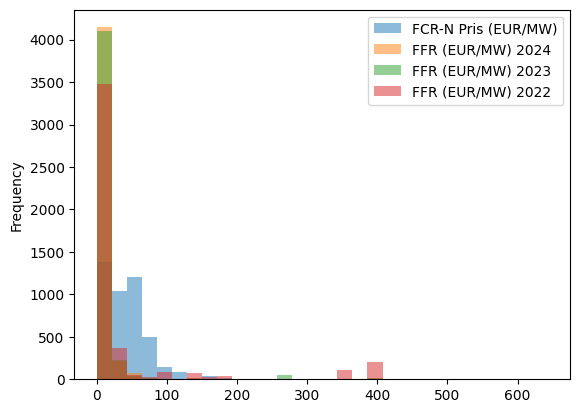

In [126]:
# make historgram with FFR prices
df_merged_notna = df_merged.dropna(subset=['FFR (EUR/MW) 2024', 'FFR (EUR/MW) 2023', 'FFR (EUR/MW) 2022'])
df_merged_notna.fillna(0).plot(kind='hist', alpha=0.5, bins=30)

C:\Users\carlv\AppData\Local\Temp\ipykernel_45132\3983047806.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_merged_notna['FCR-N Pris (EUR/MW)'].fillna(0).plot(kind='hist', alpha=0.5, bins=30)


<Axes: ylabel='Frequency'>

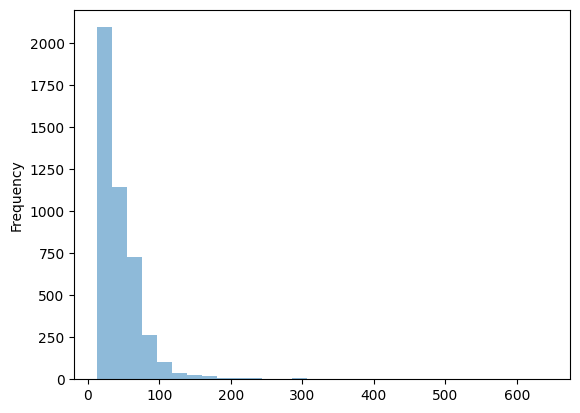

In [129]:
df_merged_notna['FCR-N Pris (EUR/MW)'].fillna(0).plot(kind='hist', alpha=0.5, bins=30)

<Axes: xlabel='Datum'>

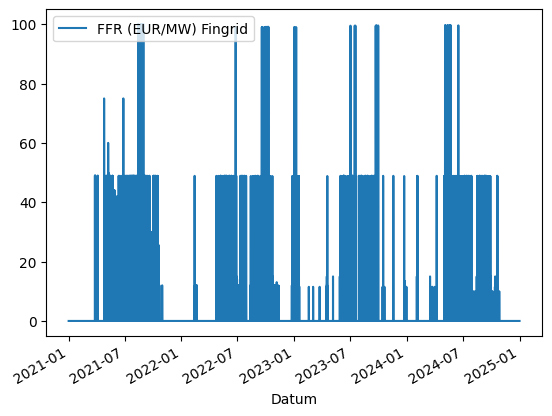

In [20]:
df_ffr_fingrid.plot(x='Datum', y='FFR (EUR/MW) Fingrid')

## mean values comparison

In [27]:
df_ffr_fingrid['FFR (EUR/MW) Fingrid'].mean()

5.187817228595891

In [41]:
df_merged.mean()

Datum                  2024-08-02 12:32:47.952326912
FCR-N Pris (EUR/MW)                        45.437019
FFR (EUR/MW) 2024                             6.1106
FFR (EUR/MW) 2023                           8.646635
FFR (EUR/MW) 2022                          33.304905
dtype: object

In [44]:
df_merged.fillna(0).mean()

C:\Users\carlv\AppData\Local\Temp\ipykernel_49772\2122555309.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_merged.fillna(0).mean()


Datum                  2024-08-02 12:32:47.952326912
FCR-N Pris (EUR/MW)                        45.437019
FFR (EUR/MW) 2024                           3.247427
FFR (EUR/MW) 2023                           4.406741
FFR (EUR/MW) 2022                          19.143705
dtype: object